# Generating waveforms

Training data for Dingo consist of pairs of parameters $\theta$ and corresponding simulated strain data sets $d_I$, where $I$ runs over the GW interferometers (L1, H1, V1, etc.). Additionally, when conditioning on detector noise properties, data also include noise context (the PSD $S_{\text{n},I}$). Strain data sets are of the form

$$
d_I = h_I(\theta) + n_I,
$$

where $h_I(\theta)$ is a *signal waveform* (provided by a waveform model) and $n_I$ is a *noise realization* (stationary and Gaussian, consistent with $S_{\text{n}, I}$).

## Data domain

At present, Dingo works entirely with frequency domain data. Although NPE is very flexible and could in principle learn to interpret data in any representation, FD data are especially convenient because (1) stationary Gaussian noise is independent in each frequency bin, so noise generation is straightforward, (2) time shifts take a simple form, enabling improved data augmentation, and (3) the noise context is already in FD. Other domains could be useful in the future, however, so the code is written in a way that the domain could be adapted.

The domain is specified by instantiating a `FrequencyDomain`,

In [4]:
from dingo.gw.domains import FrequencyDomain
domain = FrequencyDomain(f_min=20.0, f_max=1024.0, delta_f=0.125)

Derived class properties include, e.g., the frequency grid. Frequency arrays run from 0 to `f_max`, as is standard for GW data analysis software.

In [7]:
domain.sample_frequencies

array([0.000000e+00, 1.250000e-01, 2.500000e-01, ..., 1.023750e+03,
       1.023875e+03, 1.024000e+03], dtype=float32)

```{note}
The window factor $w$ used when FFTing from time domain data is also stored within the domain, in `domain.window_factor`. This enters into the standard deviation of white noise in each frequency bin, `domain.noise_std`. In frequency domain, this is given by $\sqrt{w/4\delta f}$.
```

Various class methods also act on data, to perform operations such as zeroing below `f_min`, truncating above `f_max`, or applying a time shift:

```{eval-rst}
.. autoclass:: dingo.gw.domains.FrequencyDomain
    :members:
```

## Waveform generator

Waveforms are generated using the `WaveformGenerator` class (or its subclass `NewInterfaceWaveformGenerator`, for employing the new LIGO waveform interface, needed for some approximants). This depends on a `Domain` as well as a waveform approximant and a reference frequency `f_ref`. In the backend, the `WaveformGenerator` class calls [LALSimulation](https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/) functions (typically `SimInspiralFD`) via the SWIG-Python interface. For time domain waveforms, `SimInspiralFD` takes care of FFTing to frequency domain. The `NewInterfaceWaveformGenerator` class calls the [gwsignal]() module, a Python interface recently implemented in LALSimulation, which is needed for employing some of the latest waveform approximants, as the `SEOBNRv5HM` and `SEOBNRv5PHM`. 

In [12]:
from dingo.gw.waveform_generator import WaveformGenerator #, NewInterfaceWaveformGenerator

wfg = WaveformGenerator(approximant='IMRPhenomXPHM', domain=domain, f_ref=20.0)
# wfg = NewInterfaceWaveformGenerator(approximant='SEOBNRv5PHM', domain=domain, f_ref=20.0)

To generate a waveform we first need to choose parameters. Here we sample parameters from a `bilby.core.prior.PriorDict`. We use the default Dingo intrinsic prior.

In [10]:
from bilby.core.prior import PriorDict
from dingo.gw.prior import default_intrinsic_dict

prior = PriorDict(default_intrinsic_dict)
prior

{'mass_1': Constraint(minimum=10.0, maximum=80.0, name=None, latex_label=None, unit=None),
 'mass_2': Constraint(minimum=10.0, maximum=80.0, name=None, latex_label=None, unit=None),
 'mass_ratio': UniformInComponentsMassRatio(minimum=0.125, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'chirp_mass': UniformInComponentsChirpMass(minimum=25.0, maximum=100.0, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'luminosity_distance': DeltaFunction(peak=1000.0, name=None, latex_label=None, unit=None),
 'theta_jn': Sine(minimum=0.0, maximum=3.141592653589793, name=None, latex_label=None, unit=None, boundary=None),
 'phase': Uniform(minimum=0.0, maximum=6.283185307179586, name=None, latex_label=None, unit=None, boundary='periodic'),
 'a_1': Uniform(minimum=0.0, maximum=0.99, name=None, latex_label=None, unit=None, boundary=None),
 'a_2': Uniform(minimum=0.0, maximum=0.99, name=None, latex_label=None, unit=None, boundary=None),
 'tilt_1

In [13]:
p = prior.sample()
p

{'mass_ratio': 0.14695196917207412,
 'chirp_mass': 26.112413236134643,
 'luminosity_distance': 1000.0,
 'theta_jn': 1.9825129173309055,
 'phase': 4.78240926990441,
 'a_1': 0.35849037959950186,
 'a_2': 0.9161034403210735,
 'tilt_1': 1.809623968430488,
 'tilt_2': 1.2974088926184701,
 'phi_12': 4.869347100057478,
 'phi_jl': 2.4985079021948513,
 'geocent_time': 0.0}

Finally, we generate the waveform. This is returned as a dictionary, with entries for each polarization. This way of representing a sample is used throughout Dingo, and will be very convenient when applying transforms (to apply extrinsic parameters, add noise, etc.).

In [23]:
h = wfg.generate_hplus_hcross(p)
h

{'h_plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
 'h_cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}

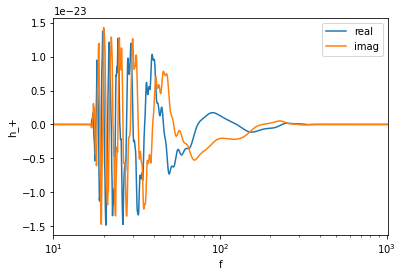

In [22]:
import matplotlib.pyplot as plt
plt.plot(domain.sample_frequencies, h['h_plus'].real, label='real')
plt.plot(domain.sample_frequencies, h['h_plus'].imag, label='imag')
plt.xlim((10,1024))
plt.xscale('log')
plt.legend()
plt.xlabel('f')
plt.ylabel(r'$h_+$')
plt.show()

Note that the waveform is nonzero slightly below `f_min`. This simply arises from the model implementation in `LALSimulation`. When training networks, input data will be truncated below `f_min`.

The complete specification of the `WaveformGenerator` class is given as
```{eval-rst}
.. autoclass:: dingo.gw.waveform_generator.WaveformGenerator
    :members:
```

### Waveform modes

Add later.